# Importing the essential libraries

In [3]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd
import re
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
%%capture
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

This project will explore a dataset of scholarly articles to gather insight about the peculiarity of different coronavirus strains (`MERS-CoV`, `SARS-CoV-1`, and `SARS-CoV-2`) that are deadly to humans and the vaccines that have been developed to tackle the outbreak to better inform our healthcare system how to tackle the COVID-19 problem.

# PART 1: Data Cleaning.
Reading in and cleaning the dataset for the analysis.

In [6]:
df = pd.read_csv('metadata.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Checking for and removing the duplicate entries and then selecting the columns that are important to the analysis.

In [7]:
# load the meta data from the CSV file and extract out fields that will be useful to our application
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df = df.dropna()
df["abstract"] = df["abstract"].str.lower()
df['title'] = df['title'].str.lower()
df.head()

,title,abstract,authors,publish_time
0,clinical features of culture-proven mycoplasma...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,surfactant protein-d and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25
3,role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321013 entries, 0 to 497905
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         321013 non-null  object
 1   abstract      321013 non-null  object
 2   authors       321013 non-null  object
 3   publish_time  321013 non-null  object
dtypes: object(4)
memory usage: 12.2+ MB


Defining a function to clean the dataset for easy analysis.

In [8]:
def data_cleaning(text):
    '''
    text: the input to clean
    election_data: the type of data we are cleaning
                    we dont want to remove hashtags(#)
    '''

    # removing trailing and leading whitespaces
    text = re.sub(r'\s+',' ',text)

    # removing all non alphabet
    text=re.sub(r'[^a-zA-Z \d]+', '', text)

    # removing stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(x for x in text.split() if x not in stop_words)

    return text

In [9]:
df['cleaned_abstract'] = df['abstract'].apply(data_cleaning)
df['title'] = df['title'].apply(data_cleaning)

In [10]:
df.head()

,title,abstract,authors,publish_time,cleaned_abstract
0,clinical features cultureproven mycoplasma pne...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,objective retrospective chart review describes...
1,nitric oxide proinflammatory mediator lung dis...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,inflammatory diseases respiratory tract common...
2,surfactant proteind pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25,surfactant proteind spd participates innate re...
3,role endothelin1 lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,endothelin1 et1 21 amino acid peptide diverse ...
4,gene expression epithelial cells response pneu...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,respiratory syncytial virus rsv pneumonia viru...


Lemmatizing the `cleaned_abstract` column to reduce the inflectional forms of some words and to reduce the vocabulary size for when TF-IDF is performed on it.

In [11]:
df['lemmatized_abstract'] = df['cleaned_abstract'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

# PART 2: Data Visualization and Exploratory Data Analysis.

Articles related to each deadly coronavirus strain is filtered out using certain keywords related to each strain (`MERS-CoV`, `SARS-CoV`, and `SARS-CoV-2`).

In [12]:
# creating keywords for each strain of coronavirus
mers_cov_keys = 'mers|merscov|emc2012|middle east respiratory syndrome'
sars_cov_1_keys = 'sarscov1|sars1|sars |sarscov '
sars_cov_2_keys = 'sarscov2|sars2|covid19|hcov19|2019ncov'

In [13]:
# filtering the whole dataset to find articles that are related to each strain
df['mers cov'] = df['lemmatized_abstract'].str.contains(mers_cov_keys)
df['sars cov 1'] = df['lemmatized_abstract'].str.contains(sars_cov_1_keys)
df['sars cov 2'] = df['lemmatized_abstract'].str.contains(sars_cov_2_keys)

In [14]:
df.head()

,title,abstract,authors,publish_time,cleaned_abstract,lemmatized_abstract,mers cov,sars cov 1,sars cov 2
0,clinical features cultureproven mycoplasma pne...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,objective retrospective chart review describes...,objective retrospective chart review describes...,False,False,False
1,nitric oxide proinflammatory mediator lung dis...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,inflammatory diseases respiratory tract common...,inflammatory disease respiratory tract commonl...,False,False,False
2,surfactant proteind pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25,surfactant proteind spd participates innate re...,surfactant proteind spd participates innate re...,False,False,False
3,role endothelin1 lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,endothelin1 et1 21 amino acid peptide diverse ...,endothelin1 et1 21 amino acid peptide diverse ...,False,False,False
4,gene expression epithelial cells response pneu...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,respiratory syncytial virus rsv pneumonia viru...,respiratory syncytial virus rsv pneumonia viru...,False,False,False


In [15]:
# counting the number of article related to each strain
mers_cov_count = df['mers cov'].sum()
sars_cov_1_count = df['sars cov 1'].sum()
sars_cov_2_count = df['sars cov 2'].sum()

print('Number of articles related to MERS-CoV: {}'.format(mers_cov_count))
print('Number of articles related to SARS-CoV-1: {}'.format(sars_cov_1_count))
print('Number of articles related to SARS-CoV-2: {}'.format(sars_cov_2_count))

Number of articles related to MERS-CoV: 8678
Number of articles related to SARS-CoV-1: 14214
Number of articles related to SARS-CoV-2: 169936


`SARS-CoV-2` (COVID-19) has `169936` scholarly articles related to it with `14214` for `SARS-CoV-1` and just `8678` for `MERS-CoV` strain. 

In [16]:
# creating a dataframe for articles related to each of the strain
df_mers_cov = df[df['mers cov'] == True]
df_sars_cov_1 = df[df['sars cov 1'] == True]
df_sars_cov_2 = df[df['sars cov 2'] == True]

Creating a collection of symptoms to explore which symptoms are prominent for each coronavirus strains. 

In [17]:
# creating the collection of symptoms
symptoms = ['insomnia', 'headache', 'fatigue', 'depression', 'dyspnea', 'anxiety', 'discharge', 'cough', 'fever', 'cold', 'sore throat', 'pneumonia']

Checking the symptoms for `MERS-CoV`.

In [18]:
symptom_count = dict((symptom,0) for symptom in symptoms)
for symptom in symptom_count:
    for abstract in df_mers_cov['lemmatized_abstract']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

symptom_count_sorted = OrderedDict(sorted(symptom_count.items(), key=lambda x: x[1]))
mers_cov_symptoms = dict(symptom_count_sorted)

Checking the symptoms for `SARS-CoV-1`.

In [19]:
symptom_count = dict((symptom,0) for symptom in symptoms)
for symptom in symptom_count:
    for abstract in df_sars_cov_1['lemmatized_abstract']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

symptom_count_sorted = OrderedDict(sorted(symptom_count.items(), key=lambda x: x[1]))
sars_cov_1_symptoms = dict(symptom_count_sorted)

Checking the symptoms for `SARS-CoV-2`.

In [20]:
symptom_count = dict((symptom,0) for symptom in symptoms)
for symptom in symptom_count:
    for abstract in df_sars_cov_2['lemmatized_abstract']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

symptom_count_sorted = OrderedDict(sorted(symptom_count.items(), key=lambda x: x[1]))
sars_cov_2_symptoms = dict(symptom_count_sorted)

In [21]:
df_virus_symptoms = pd.DataFrame([mers_cov_symptoms, sars_cov_1_symptoms, sars_cov_2_symptoms], index=['MERS-CoV', 'SARS-CoV-1', 'SARS-CoV-2'])
df_virus_symptoms = df_virus_symptoms.div(df_virus_symptoms.sum(axis=1), axis=0)
df_virus_symptoms

,insomnia,sore throat,dyspnea,headache,fatigue,depression,discharge,anxiety,cold,cough,fever,pneumonia
MERS-CoV,0.005699,0.019377,0.028875,0.041033,0.041793,0.043693,0.052812,0.056991,0.080927,0.118541,0.187690,0.322568
SARS-CoV-1,0.005369,0.021709,0.033847,0.041083,0.044118,0.030812,0.062792,0.047852,0.062558,0.128852,0.202148,0.318861
SARS-CoV-2,0.012216,0.015357,0.038955,0.030637,0.043628,0.086849,0.119076,0.133949,0.019759,0.117486,0.152874,0.229214


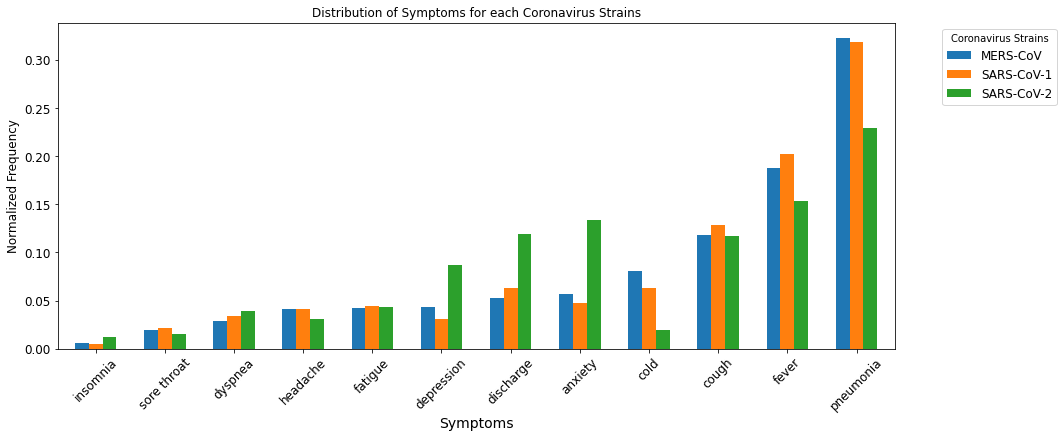

In [22]:
df_virus_symptoms.T.plot.bar(figsize=(15, 6), width=0.6, rot=45)
plt.legend(title='Coronavirus Strains', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.xlabel('Symptoms', fontsize=14)
plt.title('Distribution of Symptoms for each Coronavirus Strains')
plt.show()

**OBSERVATION:** From the graph showing the distribution of symptoms for each coronavirus strain, it can be observed the `Pneumonia`, `Fever` and `Cough` are the major symptoms for the three strains. Also, with `SARS-CoV-2` being the latest strain, it has other symptoms (`Depression`, `Discharge`, `Anxiety`) that are not common in the other two strains. This is an indication that the `SARS-CoV-2` is different compared to the other two strains.

Exploring the vaccines that have been used to control the spread of the three deadly strains of coronavirus. Vaccines to be explored:
- `Pfizer-BioNTech`
- `Moderna`
- `Janssen (Johnson & Johnson)`
- `AstraZeneca`

In [23]:
# creating the keywords for each vaccine
pfizer_biontech_keys = 'bnt162b2|pfizer|biontech'
moderna_keys = 'mrna1273|moderna'
johnson_keys = 'jnj78436735|janssen|johnson|jj'
astrazeneca_keys = 'astrazeneca|chadOx1s|covishield|verity'

Checking the frequency of occurence for each vaccine in articles that are related to MERS-CoV.

In [24]:
df_mers_cov['pfizer'] = df_mers_cov['lemmatized_abstract'].str.contains(pfizer_biontech_keys)
df_mers_cov['moderna'] = df_mers_cov['lemmatized_abstract'].str.contains(moderna_keys)
df_mers_cov['johnson'] = df_mers_cov['lemmatized_abstract'].str.contains(johnson_keys)
df_mers_cov['astrazeneca'] = df_mers_cov['lemmatized_abstract'].str.contains(astrazeneca_keys)

In [25]:
# Counts for number of article related to each strain of deadly human coronavirus
mers_pfizer_count = df_mers_cov['pfizer'].sum()
mers_moderna_count = df_mers_cov['moderna'].sum()
mers_johnson_count = df_mers_cov['johnson'].sum()
mers_astrazeneca_count = df_mers_cov['astrazeneca'].sum()

mers_vax = {'Pfizer':mers_pfizer_count, 'Moderna':mers_moderna_count, 'JJ-Janssen':mers_johnson_count, 'AstraZeneca':mers_astrazeneca_count}
print('Number of times each vaccine was mentioned in articles related to MERS-CoV.\nPfizer: {}\nModerna: {}\nJohnson: {}\nAstraZeneca: {}'
.format(mers_pfizer_count, mers_moderna_count, mers_johnson_count, mers_astrazeneca_count))

Number of times each vaccine was mentioned in articles related to MERS-CoV.
Pfizer: 7
Moderna: 6
Johnson: 64
AstraZeneca: 482


Exploring the frequency of occurence for each vaccine in articles that are related to SARS-CoV-1.

In [26]:
df_sars_cov_1['pfizer'] = df_sars_cov_1['lemmatized_abstract'].str.contains(pfizer_biontech_keys)
df_sars_cov_1['moderna'] = df_sars_cov_1['lemmatized_abstract'].str.contains(moderna_keys)
df_sars_cov_1['johnson'] = df_sars_cov_1['lemmatized_abstract'].str.contains(johnson_keys)
df_sars_cov_1['astrazeneca'] = df_sars_cov_1['lemmatized_abstract'].str.contains(astrazeneca_keys)

In [27]:
# Counts for number of article related to each strain of deadly human coronavirus
sars1_pfizer_count = df_sars_cov_1['pfizer'].sum()
sars1_moderna_count = df_sars_cov_1['moderna'].sum()
sars1_johnson_count = df_sars_cov_1['johnson'].sum()
sars1_astrazeneca_count = df_sars_cov_1['astrazeneca'].sum()

sars1_vax = {'Pfizer':sars1_pfizer_count, 'Moderna':sars1_moderna_count, 'JJ-Janssen':sars1_johnson_count, 'AstraZeneca':sars1_astrazeneca_count}
print('Number of times each vaccine was mentioned in articles related to SARS-CoV-1.\nPfizer: {}\nModerna: {}\nJohnson: {}\nAstraZeneca: {}'
.format(sars1_pfizer_count, sars1_moderna_count, sars1_johnson_count, sars1_astrazeneca_count))

Number of times each vaccine was mentioned in articles related to SARS-CoV-1.
Pfizer: 16
Moderna: 19
Johnson: 18
AstraZeneca: 790


Checking the frequency of occurence for each vaccine in articles that are related to SARS-CoV-2.

In [28]:
df_sars_cov_2['pfizer'] = df_sars_cov_2['lemmatized_abstract'].str.contains(pfizer_biontech_keys)
df_sars_cov_2['moderna'] = df_sars_cov_2['lemmatized_abstract'].str.contains(moderna_keys)
df_sars_cov_2['johnson'] = df_sars_cov_2['lemmatized_abstract'].str.contains(johnson_keys)
df_sars_cov_2['astrazeneca'] = df_sars_cov_2['lemmatized_abstract'].str.contains(astrazeneca_keys)

In [29]:
# Counts for number of article related to each strain of deadly human coronavirus
sars2_pfizer_count = df_sars_cov_2['pfizer'].sum()
sars2_moderna_count = df_sars_cov_2['moderna'].sum()
sars2_johnson_count = df_sars_cov_2['johnson'].sum()
sars2_astrazeneca_count = df_sars_cov_2['astrazeneca'].sum()

sars2_vax = {'Pfizer':sars2_pfizer_count, 'Moderna':sars2_moderna_count, 'JJ-Janssen':sars2_johnson_count, 'AstraZeneca':sars2_astrazeneca_count}
print('Number of times each vaccine was mentioned in articles related to SARS-CoV-1.\nPfizer: {}\nModerna: {}\nJohnson: {}\nAstraZeneca: {}'
.format(sars2_pfizer_count, sars2_moderna_count, sars2_johnson_count, sars2_astrazeneca_count))

Number of times each vaccine was mentioned in articles related to SARS-CoV-1.
Pfizer: 304
Moderna: 189
Johnson: 193
AstraZeneca: 12547


In [30]:
# normalizing the occurence of the vaccines for each strain for visualization
df_strains_vaccine = pd.DataFrame([mers_vax, sars1_vax, sars2_vax], index=['MERS-CoV', 'SARS-CoV-1', 'SARS-CoV-2'])
df_strains_vaccine = df_strains_vaccine.div(df_strains_vaccine.sum(axis=1), axis=0)
df_strains_vaccine

,Pfizer,Moderna,JJ-Janssen,AstraZeneca
MERS-CoV,0.012522,0.010733,0.114490,0.862254
SARS-CoV-1,0.018980,0.022539,0.021352,0.937129
SARS-CoV-2,0.022973,0.014282,0.014585,0.948160


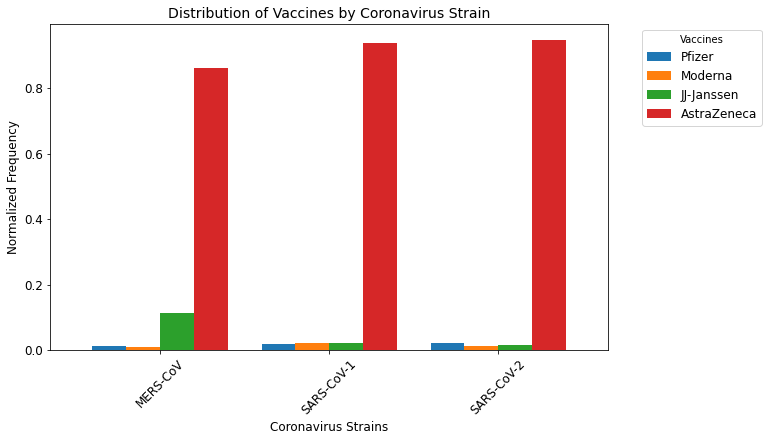

In [31]:
df_strains_vaccine.plot.bar(figsize=(10, 6), width=0.8, rot=45, fontsize=12)
plt.legend(title='Vaccines', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.xlabel('Coronavirus Strains', fontsize=12)
plt.title('Distribution of Vaccines by Coronavirus Strain', fontsize=14)
plt.show()

**OBSERVATION:** From the graph showing how frequently each vaccine co-occur wuth each strain of the virus, It is apparent that the `AstraZeneca` vaccine has more occurence with the three strains of virus. This is an indication that much scientific research has been carried out on `AstraZeneca Vaccine` with regards to the previous and current strains of the coronavirus; and less attention has been given to other Covid-19 vaccines.

Investigating prominent vaccines among countries that have been able to efficiently tackle the spread of covid-19 in their nation. Some of the countries are:
 - `Singapore`
 - `Taiwan`
 - `South Korea`
 - `New Zealand`
 - `Australia`
 - `UAE`
 - `China`

In [32]:
# creating a function to get the count of the vaccines per country
def vaccine_by_country(country):
    country_dict = dict()
    country_article = df[df['lemmatized_abstract'].str.contains(country)]

    country_article['Pfizer'] = country_article['lemmatized_abstract'].str.contains(pfizer_biontech_keys)
    country_article['Moderna'] = country_article['lemmatized_abstract'].str.contains(moderna_keys)
    country_article['Johnson'] = country_article['lemmatized_abstract'].str.contains(johnson_keys)
    country_article['AstraZeneca'] = country_article['lemmatized_abstract'].str.contains(astrazeneca_keys)

    # Counts for number of article related to each strain of deadly human coronavirus
    country_pfizer_count = country_article['Pfizer'].sum()
    country_moderna_count = country_article['Moderna'].sum()
    country_johnson_count = country_article['Johnson'].sum()
    country_astrazeneca_count = country_article['AstraZeneca'].sum()

    country_dict['Pfizer'] = country_pfizer_count
    country_dict['Moderna'] = country_moderna_count
    country_dict['Johnson'] = country_johnson_count
    country_dict['AstraZeneca'] = country_astrazeneca_count

    return country_dict

countries = ['singapore', 'taiwan', 'south korea', 'new zealand', 'australia', 'uae', 'china']
country_list = list()
for country in countries:
    country_result = vaccine_by_country(country)
    country_list.append(country_result)

df_country_result = pd.DataFrame(country_list, index=[country.capitalize() for country in countries])
df_country_result = df_country_result.div(df_country_result.sum(axis=1), axis=0)

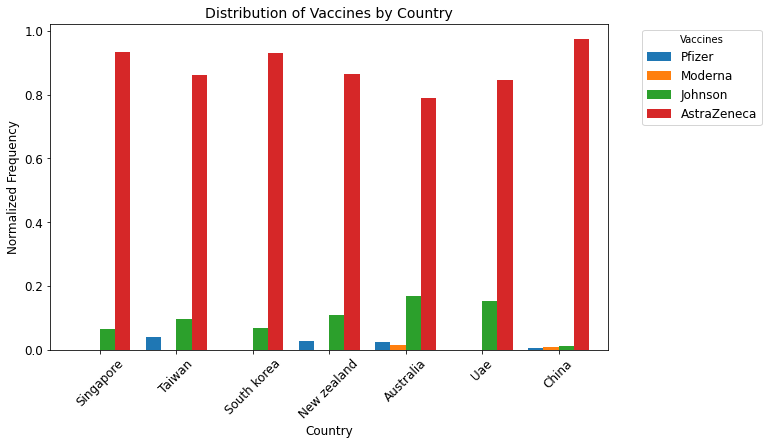

In [33]:
df_country_result.plot.bar(figsize=(10, 6), width=0.8, rot=45, fontsize=12)
plt.legend(title='Vaccines', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.title('Distribution of Vaccines by Country', fontsize=14)
plt.show()

**OBSERVATION:** As shown in the distribution of It can be said that the `AstraZeneca Vaccine` happen to have more occurence with the countries that were able mitigate the spread of the virus compared to other vaccines. This implies that the `AstraZeneca Vaccine` might be a good vaccination option to control the spread of Covid-19.

# PART 3: Model Selection and Fitting to Data.
Designing an unsupervised model that will group scholarly articles relating to vaccine. This model will help scientist to easily get articles that will aid their research of finding a more efficient vaccine that will flatten the curve of the pandemic.

`KMeans` clustering will be used for grouping of the articles.

Gathering all research papers related to vaccine.

In [34]:
# creating keywords related to vaccine
vaccine_keys = 'vaccine|therapeutic|prophylactic|' + pfizer_biontech_keys + '|' + moderna_keys + '|' + johnson_keys + '|' + astrazeneca_keys

In [35]:
vaccine_articles = df[df['lemmatized_abstract'].str.contains(vaccine_keys)]

Creating a TF-IDF feature for the vaccine-related articles and limiting the number of features created to the top `1000` features ordered by term frequency across the corpus.

In [36]:
 # Applying Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_feature = vectorizer.fit_transform(vaccine_articles['abstract'].values)

Performing hyperparameter tuning on the `KMeans` model to see the number of clusters `K` that will efficiently group the articles.

We choose the best number of clusters by calculating the sum of squared distances of samples to their closest cluster center. This metric measure can be obtained from the `.inertia_` attribute of the KMeans model.

The ideal number of clusters would be choosing the number of clusters to be equal to the number of data points which will make the sum of squared distance into zero; however this doesn’t make any sense as we have as many clusters as the observations. Therefore, we need to use a method called `Elbow Method` for selecting the optimal number of clusters.

The elbow method works by selecting a reasonable range of number of clusters then plotting it against the sum of squared distance for each K value.

In [37]:
sum_squared_dist = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=1)
    kmeans.fit(tfidf_feature)
    sum_squared_dist.append(kmeans.inertia_)

Plotting the elbow method graph.

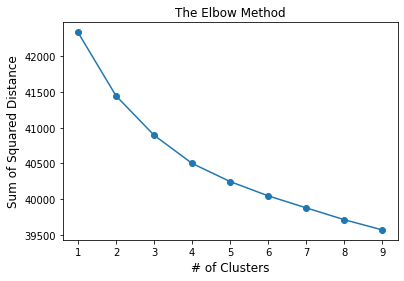

In [38]:
#Plot for the Elbow Method
plt.plot(range(1,10), sum_squared_dist, marker='o')
plt.title('The Elbow Method', fontsize=12)
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Sum of Squared Distance', fontsize=12)
plt.show()

An optimal `K` value is selected when there is a small decrease in sum of squared distance per increase in number of clusters.
From `The Elbow Method` graph above, the optimal number of clusters will be 4. This is because there's a reasonable drop in the distance metric from `K=1` to `K=4` and after 4, there is a small drop.

Grouping the vaccine-related articles into four clusters.

In [39]:
kmeans_tfidf = KMeans(n_clusters=4, random_state=0, n_init=1)
y_pred_tfidf = kmeans_tfidf.fit_predict(tfidf_feature)
vaccine_articles['cluster_label'] = kmeans_tfidf.labels_

Reducing the dimensionality of the TF-IDF features into 3 using Principal Component Analysis (PCA) just for visualization purpose.

In [40]:
pca_tfidf = PCA(n_components=3)
pca_tfidf_data = pca_tfidf.fit_transform(tfidf_feature.toarray())
centroids_tfidf =  pca_tfidf.transform(kmeans_tfidf.cluster_centers_)

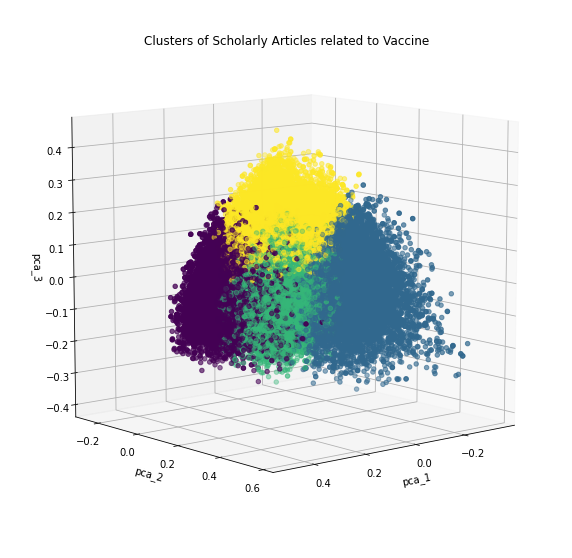

In [41]:
ax = plt.figure(figsize=(10,10)).gca(projection='3d')
ax.view_init(10, 50)
ax.scatter(xs=pca_tfidf_data[:,0], ys=pca_tfidf_data[:,1], zs=pca_tfidf_data[:,2], c=y_pred_tfidf)
ax.set_xlabel('pca_1')
ax.set_ylabel('pca_2')
ax.set_zlabel('pca_3')
plt.title('Clusters of Scholarly Articles related to Vaccine')
plt.show()

Number of articles in each cluster.

In [42]:
vaccine_articles['cluster_label'].value_counts()

2    16710
3    14843
0    12809
1     9003
Name: cluster_label, dtype: int64

In [43]:
cluster_0 = vaccine_articles.loc[vaccine_articles['cluster_label']==0, 'lemmatized_abstract']
cluster_1 = vaccine_articles.loc[vaccine_articles['cluster_label']==1, 'lemmatized_abstract']
cluster_2 = vaccine_articles.loc[vaccine_articles['cluster_label']==2, 'lemmatized_abstract']
cluster_3 = vaccine_articles.loc[vaccine_articles['cluster_label']==3, 'lemmatized_abstract']

In [44]:
vectorizers = []
for _ in range(0, 4):
    # Creating 4 tfidf vectorizers
    vectorizers.append(TfidfVectorizer(max_features=1000))

In [45]:
cluster_0_tfidf = vectorizers[0].fit_transform(cluster_0.values)
cluster_1_tfidf = vectorizers[1].fit_transform(cluster_1.values)
cluster_2_tfidf = vectorizers[2].fit_transform(cluster_2.values)
cluster_3_tfidf = vectorizers[3].fit_transform(cluster_3.values)

With the separation of the articles into their respective clusters, we are going to use the `Latent Dirichlet Allocation (LDA)` for `Topic Modelling` for each clusters of scholarly articles.

LDA is an unsupervised machine learning method that is specifically designed for topic modelling.

Building LDA Models for the four clusters with `sklearn`. We are going to find the optimal number of topics for each cluster using `GridSearchCV`. Some default parameters have been set such as:
 - `random_state=0`: for consistency in result.
 - `n_jobs=-1`: to use all processors for computation.
 - `learning_method='online'`:  because of the large data size.

Hyperparameters to be tuned for each model are:
 - `n_componenets`: number of topics. 

In [125]:
# params = {'n_components': [1, 2, 3]}
# best_models = dict()

# for index, cluster_tfidf in enumerate([cluster_0_tfidf, cluster_1_tfidf, cluster_2_tfidf, cluster_3_tfidf]):
#     # tuning the best lda model for each cluster
#     lda = LatentDirichletAllocation(random_state=0, n_jobs=-1, learning_method='online')
#     grid = GridSearchCV(lda, param_grid=params)
#     grid.fit(cluster_tfidf)

#     best_lda_model = grid.best_estimator_
#     best_models['lda {}'.format(index)] = grid.best_params_

The code in the cell above takes time to run, so after the optimal parameters have been obtained, the code was commented out.

Creating the four LDA models with their optimal hyperparameters.

In [126]:
best_models

{'lda 0': {'n_components': 1},
 'lda 1': {'n_components': 1},
 'lda 2': {'n_components': 1},
 'lda 3': {'n_components': 1}}

Since the optimal number of topics (`n_components`) for each cluster is 1, according to the hyperparameter tuning, four `LDA` models will be created for the four clusters setting `1` as the number of topics.

In [46]:
# creating the four lda models
lda_models = []
for _ in range(4):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=1, learning_method='online', random_state=0, n_jobs = -1)
    lda_models.append(lda)

In [47]:
lda_0_result = lda_models[0].fit_transform(cluster_0_tfidf)
lda_1_result = lda_models[1].fit_transform(cluster_1_tfidf)
lda_2_result = lda_models[2].fit_transform(cluster_2_tfidf)
lda_3_result = lda_models[3].fit_transform(cluster_3_tfidf)

Creating a function that will show the top 15 keywords in a topic for each cluster.

In [48]:
# funtin to show top 15 keywords for each topic
def top_keywords(vectorizer, lda_model):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:15]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

#### Topic for Cluster 0

In [49]:
cluster0_topic_keywords = top_keywords(vectorizers[0], lda_models[0])        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(cluster0_topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,patient,covid19,disease,group,study,severe,clinical,severity,ci,95,case,mortality,risk,infection,symptom



The distinc topic keywords in relation to other clusters are `severe`, `mortality` and `risk`. Cluster 0 holds research papers that would be useful if a scientist wants to do a research on the vaccine based on the severity of the virus.

#### Topic for Cluster 1

In [50]:
cluster1_topic_keywords = top_keywords(vectorizers[1], lda_models[1])        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(cluster1_topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,sarscov2,covid19,protein,vaccine,infection,cell,coronavirus,drug,antibody,virus,disease,viral,respiratory,response,patient


According to the topic keywords in cluster 1, the articles in this cluster will be useful for studies that are related to how the coronavirus propagates through the cell of humans and roles played by the antibodies.

#### Topic for Cluster 2

In [51]:
cluster2_topic_keywords = top_keywords(vectorizers[2], lda_models[2])        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(cluster2_topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,vaccine,virus,cell,infection,disease,viral,protein,response,influenza,therapeutic,study,human,immune,antibody,treatment


The top topic keywords in cluster 2 are `vaccine` and `virus`. This cluster has a perfect collection of articles that directly talks about the vaccine and the virus.

#### Topic for Cluster 3

In [52]:
cluster3_topic_keywords = top_keywords(vectorizers[3], lda_models[3])        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(cluster3_topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,covid19,patient,disease,vaccine,pandemic,health,treatment,infection,study,clinical,coronavirus,case,sarscov2,drug,therapeutic


This cluster contains keywords relating to the different approach that have been explored to treat patients of the COVID-19.

# PART 4: Deriving Insights about Policy and Guidance to tackle the Outbreak based on Model Findings.

From the exploration conducted on the research articles, it was observed that  the COVID-19 (SARS-CoV-2) strain is different from the other strains that are deadly to humans. Symptoms like discharge, anxiety and depression are common with COVID-19 but cold is not that common compared to the other two strains.

Also, the AstraZeneca vaccine has more occurrence with the three strains of covid 19 and also popular among the top countries that responded well to the pandemic.

Based on the high co-occurrence of AstraZeneca vaccine with the two previous strains of coronavirus in same article, it shows that the deadly strain of the coronavirus was put into consideration while creating the vaccine not considering the fact that COVID-19 is different. This might be the reason for the 70% effectiveness of the Astrazeneca vaccine.

To help improve the vaccination effort, an unsupervised machine learning model was built using KMeans algorithm has been designed to cluster vaccine-related articles and Latent Dirichlet was used for the topic modelling for each clusters. The model will allow scientist to easily get vaccine-related articles that are significant to their study of creation of a more effective vaccine either revisit the creation of AstraZeneca vaccine considering only the COVID-19 strain of the coronavirus or to explore other potential vaccine like the Moderna, Pfizer and Moderna vaccine.

Recommendation for our healthcare system is to revisit the creation of new vaccine putting into consideration only the COVID-19 strain or to explore the already existing vaccine like the Moderna, Pfizer and Johnson & Johnson Vaccine.
